In [7]:
import os
import librosa
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [3]:
# Hàm trích xuất MFCC cùng với delta và delta-delta
def extract_mfcc_with_deltas(audio, sr=16000, n_mfcc=13):
    hop_length = int(0.01 * sr)  # Bước nhảy 10 ms
    win_length = int(0.025 * sr)  # Cửa sổ 25 ms
    
    # Tính toán MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, win_length=win_length, window='hamming')
    
    # Tính toán delta (đạo hàm bậc nhất)
    mfcc_delta = librosa.feature.delta(mfccs)
    
    # Tính toán delta-delta (đạo hàm bậc hai)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    
    # Gộp MFCCs, delta và delta-delta
    mfcc_combined = np.vstack([mfccs, mfcc_delta, mfcc_delta2])
    
    return mfcc_combined

In [4]:
# Hàm tải dữ liệu từ thư mục
def load_data(data_dir):
    X = []
    y = []
    labels = os.listdir(data_dir)
    
    for label in labels:
        label_dir = os.path.join(data_dir, label)
        for file_name in os.listdir(label_dir):
            if file_name.endswith(".wav"):
                file_path = os.path.join(label_dir, file_name)
                # Tải file âm thanh
                audio, sr = librosa.load(file_path, sr=None)
                features = extract_mfcc_with_deltas(audio, sr)
                X.append(np.mean(features, axis=1))  # Tính trung bình các đặc trưng theo thời gian
                y.append(label)
    
    return np.array(X), np.array(y)


In [5]:
# Đường dẫn tới dữ liệu huấn luyện và kiểm thử
train_data_dir = r'C:\Users\USER\Downloads\SV_NCKH_audio_event\Train'
test_data_dir = r'C:\Users\USER\Downloads\SV_NCKH_audio_event\Test'

# Tải dữ liệu
X_train, y_train = load_data(train_data_dir)
X_test, y_test = load_data(test_data_dir)

# Chuẩn hóa nhãn
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Chuẩn hóa đặc trưng (z-score)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Xây dựng và huấn luyện mô hình KNN
knn = KNeighborsClassifier(n_neighbors=5)  # Bạn có thể thay đổi số lượng hàng xóm
knn.fit(X_train, y_train)

# Dự đoán trên tập kiểm thử
y_pred = knn.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Accuracy: 0.4499
Classification Report:
              precision    recall  f1-score   support

      Sound0       0.48      0.36      0.41        67
      Sound1       0.22      0.34      0.27        44
     Sound10       0.67      0.61      0.64        64
     Sound11       0.36      0.34      0.35        47
     Sound12       0.18      0.14      0.16        14
     Sound13       0.80      1.00      0.89        51
     Sound14       0.91      0.70      0.79        30
     Sound15       1.00      0.50      0.67         2
     Sound16       0.16      0.05      0.07        66
     Sound17       0.25      0.52      0.34        64
     Sound18       0.00      0.00      0.00         8
     Sound19       0.00      0.00      0.00        23
      Sound2       1.00      0.95      0.97        55
     Sound20       0.27      0.61      0.37        46
      Sound3       0.88      1.00      0.94        15
      Sound4       0.55      0.30      0.39        88
      Sound5       0.00      0.00      0.

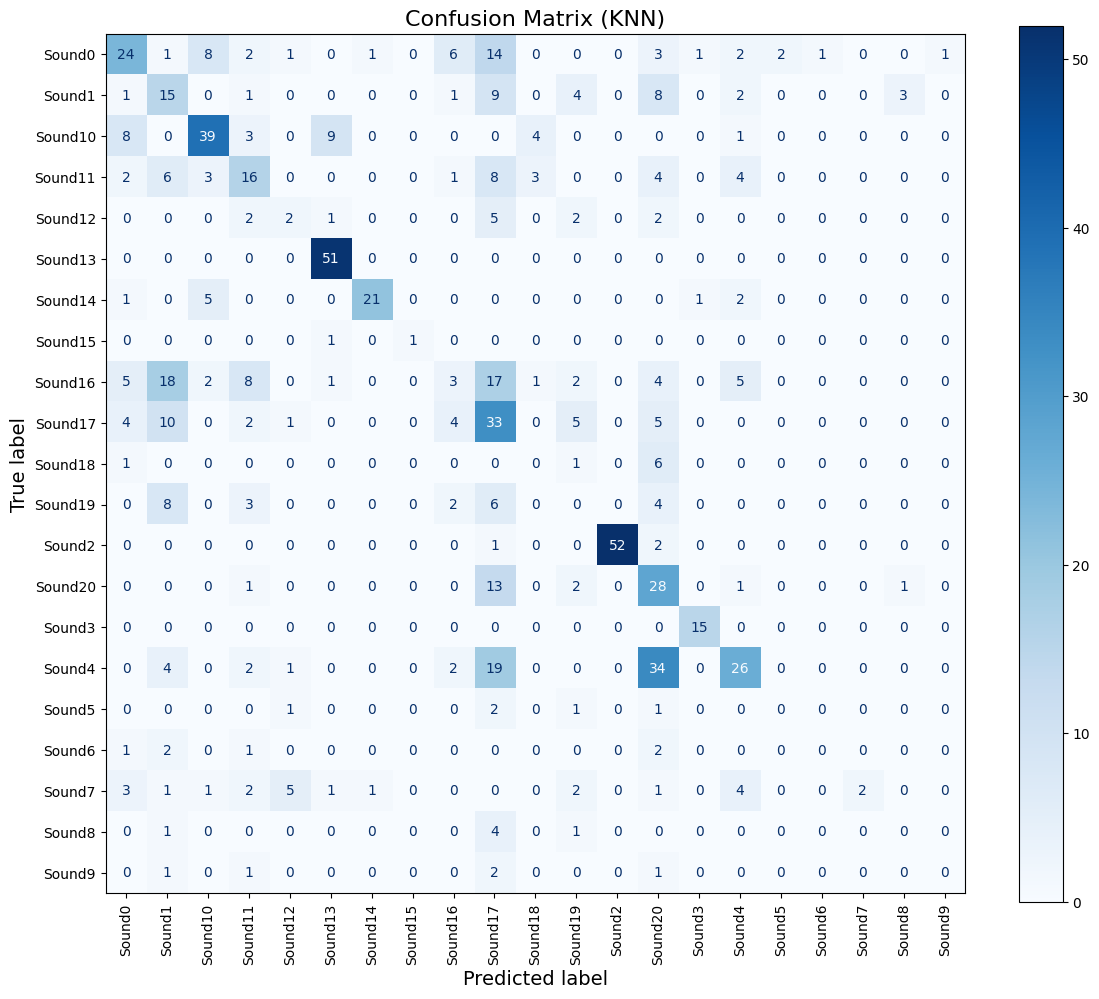

In [ ]:
# Làm phẳng dữ liệu (nếu chưa làm)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

# Khởi tạo mô hình KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_flat, y_train)

# Dự đoán trên tập test
y_pred_knn = knn_model.predict(X_test_flat)

# Tính toán ma trận nhầm lẫn
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Hiển thị ma trận nhầm lẫn
fig, ax = plt.subplots(figsize=(12, 10))
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=le.classes_)
disp_knn.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix (KNN)", fontsize=16)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.tight_layout()
plt.show()